# Creating the ideal Spotify Playlist for myself

## Grabbing data from the Spotify API with spotipy

In [24]:
# Scraping song lyrics from Genius and Spotify
# Spotify client ID: 2573a6dc58484146b0434289ffe03af5
# Spotify client Secret: 78ca0bfc6e77486991c3faa1d507afc2
# user_id = this will probably be a list, will test with https://open.spotify.com/user/spotify?si=3991b93174d04be3
# playlist_id = also a list, testing with https://open.spotify.com/playlist/37i9dQZF1E35BhKQRss82L
# This particular class scrapes a playlist for lyrics, will need to find a way to extrapolate this out to multiple playlists/ an entire category. May need to look at creating a list of user/playlist IDs to loop over? 
# Will use this class if I have time, building model first with Kaggle data. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from flask import Flask

spotify_client_id = '2573a6dc58484146b0434289ffe03af5'
spotify_client_secret = '78ca0bfc6e77486991c3faa1d507afc2'
user_id = '3991b93174d04be3'
playlist_id = '37i9dQZF1E35BhKQRss82L'

#a class to scrape Spotify for playlist information using Spotify artist/track information. With more time I am going to build on this class and append to a new dataframe, applying my KMEANS model to this data to build playlists which are more applicable for me.
class GetSpotifyInfo():
    
    #initializing class
    def __init__(self, spotify_client_id, spotify_client_secret, user_id, playlist_id):
        self.spotify_client_id = spotify_client_id
        self.spotify_client_secret = spotify_client_secret
        self.user_id = user_id
        self.playlist_id = playlist_id

    #function to use Spotify credentials to get playlist tracks using API credentials and user/playlist ID    
    def get_playlist_info(self):
        credentials = SpotifyClientCredentials(client_id = self.spotify_client_id, client_secret = self.spotify_client_secret)
        sp = spotipy.Spotify(client_credentials_manager=credentials)
        playlist = sp.user_playlist_tracks(self.user_id, self.playlist_id)
        self.playlist = playlist
        return self.playlist
    
    #appends track names into a list
    def get_track_names(self):
        track_names = []
        for song in range(len(self.playlist['items'])):
            track_names.append(self.playlist['items'][song]['track']['name'])
        print(*track_names)
        self.track_names = track_names
        return self.track_names
    
    #appends artist names into a list
    def get_track_artists(self):
        track_artists = []
        for song in range(len(self.playlist['items'])):
            track_artists.append(self.playlist['items'][song]['track']['artists'][0]['name'])
        self.track_artists = track_artists
        return self.track_artists

    #get track id, feed this list into audio features function to get audio features for this playlist.
    def get_track_id(self):
        track_id = []
        for song in range(len(self.playlist['items'])):
            track_id.append(self.playlist['items'][song]['track']['id'])
        self.track_id = track_id
        return self.track_id

## Initializing song features (numeric) CSV for proof of concept on existing dataframe

In [25]:
#initializing song features (numeric) csv

spotify_song_features = pd.read_csv("/Users/sabinagrossman/Desktop/spotify_songs.csv")  
spotify_song_features_copy = spotify_song_features[['liveness', 'tempo', 'energy', 'loudness', 'danceability']]
spotify_song_features_copy.head()

,liveness,tempo,energy,loudness,danceability
0,0.0887,97.091,0.401,-10.068,0.682
1,0.3470,135.225,0.880,-4.739,0.303
2,0.4890,111.904,0.652,-7.504,0.845
3,0.0664,118.593,0.378,-5.819,0.425
4,0.1380,130.018,0.887,-1.993,0.760


## Initial KMeans analysis with numerical data from Kaggle

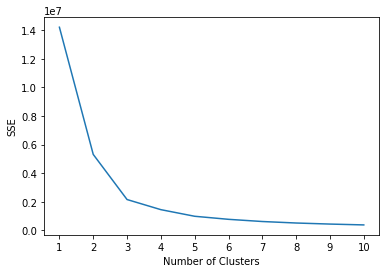

In [26]:
#elbow graph to determine ideal number of clusters for kmeans model with numerical data (unscaled data)

#kmeans parameters
kmeans_params = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each value of k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_params)
    kmeans.fit(spotify_song_features_copy)
    sse.append(kmeans.inertia_)

#visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#bends at 2 and 3 for indication of ideal number of clusters

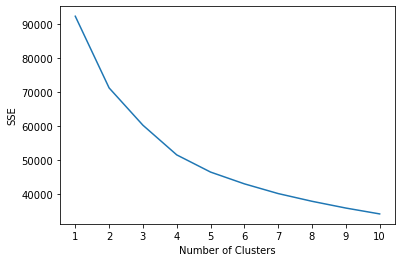

In [27]:
#trying out elbow method a second time on standard scaled data, which helps with differences in scale between characteristics of the dataset

scaled_song_features = StandardScaler().fit_transform(spotify_song_features_copy)

#create list to hold SSE values for each value of k
sse2 = []
for k in range(1, 11):
    kmeans2 = KMeans(n_clusters=k, **kmeans_params)
    kmeans2.fit(scaled_song_features)
    sse2.append(kmeans2.inertia_)

# #visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse2)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#elbow graph is more subtle with standard scaler involved but bends are at 2 and 4, indicating ideal number of clusters

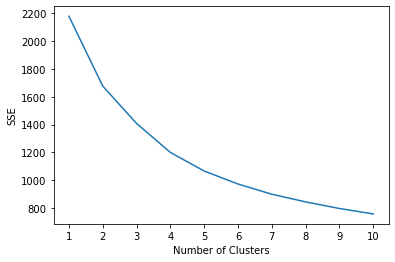

In [28]:
#trying out elbow method a second time on standard scaled data, which helps with differences in scale between characteristics of the dataset

scaled_song_features2 = MinMaxScaler().fit_transform(spotify_song_features_copy)

#create list to hold SSE values for each value of k
sse3 = []
for k in range(1, 11):
    kmeans3 = KMeans(n_clusters=k, **kmeans_params)
    kmeans3.fit(scaled_song_features2)
    sse3.append(kmeans3.inertia_)

# #visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse3)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#elbow graph is more subtle with standard scaler involved but bends are at 2 and 4, indicating ideal number of clusters

In [29]:
#instantiate the k-means class, using optimal number of clusters found by analyzing elbow curve above (going with 4, might try others depending on the clusters graph)
kmeans = KMeans(init='k-means++', n_clusters=4, n_init=10, random_state=1, max_iter = 300)

#fitting the model to the data, predicting clusters
labels = kmeans.fit_predict(scaled_song_features2)

#adding the cluster labels to the dataframe so that I can look at attributes of the data later on
spotify_song_features_copy['kmeans_cluster'] = kmeans.labels_
spotify_song_features_copy.head()

/var/folders/zk/l8v61ht16ks5jp_8swnq6lhw0000gn/T/ipykernel_45099/2798718357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify_song_features_copy['kmeans_cluster'] = kmeans.labels_


,liveness,tempo,energy,loudness,danceability,kmeans_cluster
0,0.0887,97.091,0.401,-10.068,0.682,1
1,0.3470,135.225,0.880,-4.739,0.303,2
2,0.4890,111.904,0.652,-7.504,0.845,0
3,0.0664,118.593,0.378,-5.819,0.425,1
4,0.1380,130.018,0.887,-1.993,0.760,3


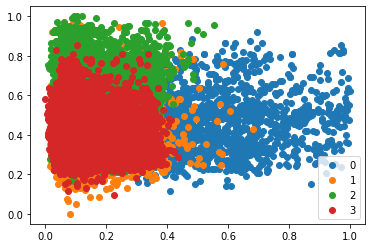

In [30]:
#get unique values for cluster labels, store in a variable for future use in plotting
unique_labels = np.unique(spotify_song_features_copy['kmeans_cluster'])

#plotting the results:
for i in unique_labels:
    plt.scatter(scaled_song_features2[labels == i , 0] , scaled_song_features2[labels == i, 1], label = i)
plt.legend()
plt.show()

## Taking a look at mean values for each component of the clusters

In [31]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 3]['tempo'].mean()
#cluster 3 has highest mean value for liveness (0.514008450704226)

111.1046789776712

In [32]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 2]['tempo'].mean()
#cluster 2 has lowest mean value for energy (energy)
#smallest value for loudness at -10.489964760793486 db

143.57317892976593

In [33]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 1]['tempo'].mean()
#cluster 1 has highest mean tempo at 149.70239097914762
#also loudest at mean of -5.463442883046225 db
#highest mean value for energy (0.792355621033543)
#lowest mean value for danceability (0.5282901178603819)

113.5706225327124

In [34]:
spotify_song_features_copy.loc[spotify_song_features_copy['kmeans_cluster'] == 0]['tempo'].mean()
#cluster 0 has lowest mean value for liveness (0.1403696420610989)
#highest mean value for danceability (0.7261779205454344)
#lowest mean value for tempo at 109.24641759538459

117.32710343137245

### Taking a look at the initial features from the kmeans analysis here, I would say that cluster 1 contains the songs with the most ideal characteristics for my purposes. It has the highest mean values for tempo, loudness, energy. It has low danceability counts, however I believe that the high values in the other characteristics make up for this.

## Initiating CSV file with english and portuguese songs for use with pretrained language recognition model FastText

In [35]:
lyricscsv = pd.read_csv("/Users/sabinagrossman/Desktop/lyrics-data.csv")
lyrics_csv = lyricscsv.drop(columns=['ALink', 'SLink'])
lyricscsv

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...,...,...
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en


In [41]:
# importing fasttext to explore the pretrained model here, predicting languages and calling module
import fasttext
pretrained_model_path = "//Users/sabinagrossman/Documents/GitHub/lid.176.bin"
model = fasttext.load_model(pretrained_model_path)

In [42]:
sentence = ['Tudo o que eu quero nessa vida', 'Sweat in the heat for days on end', 'Je suis un chien']
model.predict(sentence)

([['__label__pt'], ['__label__en'], ['__label__fr']],
 [array([0.9250701], dtype=float32),
  array([0.8138323], dtype=float32),
  array([0.9999173], dtype=float32)])

In [43]:
model.get_sentence_vector('Sweat in the heat for days on end')

array([ 0.06193198,  0.06496201, -0.14206967,  0.01037472, -0.08264644,
       -0.01400864,  0.03766745, -0.02698757,  0.00186228, -0.14544761,
       -0.06429534, -0.0360456 ,  0.13938498, -0.09937723, -0.04525438,
        0.11286927], dtype=float32)

In [44]:
lyrics_csv = lyrics_csv.dropna()
lyrics_csv

,SName,Lyric,language
0,Arerê,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,Se Eu Não Te Amasse Tanto Assim,Meu coração\nSem direção\nVoando só por voar\n...,pt
2,Céu da Boca,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt
3,Quando A Chuva Passar,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt
4,Sorte Grande,A minha sorte grande foi você cair do céu\nMin...,pt
...,...,...,...
379926,The Waiting,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,Too Early For The Sky,I nearly disappeared into the mouth of a croco...,en
379928,Warsaw 1943 (I Never Betrayed The Revolution),"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,When The System Has Fallen,Sweat in the heat for days on end\nwaiting for...,en


In [45]:
def get_vectors(sentence):
    return model.get_sentence_vector(sentence)

In [46]:
lyrics_replace = lyrics_csv['Lyric'].str.replace('\n', '')

In [47]:
lyrics_vectors = lyrics_replace.apply(lambda x : get_vectors(x))

In [48]:
df_vectors = pd.DataFrame(lyrics_vectors.tolist())

In [49]:
#can concatenate everything together, repeat kmeans steps to get final clusters and then work on initial deployment
concat_df = pd.concat([df_vectors, spotify_song_features_copy], axis=1)
concat_df = concat_df.fillna(0)
concat_df_copy = concat_df.copy()

In [50]:
#scaling data with minmax, since we determined above that this is a better method than standardscaler

ssf_vectors = MinMaxScaler().fit_transform(concat_df_copy)

/Users/sabinagrossman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/sabinagrossman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


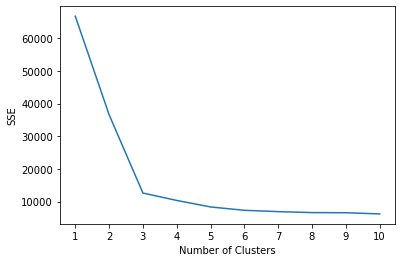

In [51]:
#elbow graph to determine ideal number of clusters for kmeans model with numerical data (MINMAX scaling datan as standardscaling was compressing it too much on other iterations)

#kmeans parameters
kmeans_params = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each value of k
sse4 = []
for k in range(1, 11):
    kmeans4 = KMeans(n_clusters=k, **kmeans_params)
    kmeans4.fit(ssf_vectors)
    sse4.append(kmeans4.inertia_)

#visualize results in order to assess bends, which indicate best number of clusters
plt.plot(range(1, 11), sse4)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#extreme bend at 3 indicates strongly that ideal number of clusters is at 3. 

In [52]:
#creating kmeans clustering model for combined df

#instantiate the k-means class, using optimal number of clusters found by analyzing elbow curve above (going with 4, might try others depending on the clusters graph)
kmeans4 = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=1, max_iter = 300)

#fitting the model to the data, predicting clusters
labels4 = kmeans4.fit_predict(ssf_vectors)

#adding the cluster labels to the dataframe so that I can look at attributes of the data later on
concat_df_copy['kmeans_cluster'] = kmeans4.labels_
concat_df_copy

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,liveness,tempo,energy,loudness,danceability,kmeans_cluster
0,0.103970,-0.393970,-0.020096,-0.491860,-0.246677,-0.020716,0.117633,-0.098620,-0.382097,0.101107,...,-0.164242,0.151750,0.245546,0.378433,0.0887,97.091,0.401,-10.068,0.682,2
1,0.057642,-0.367321,0.015674,-0.401540,-0.249008,-0.047280,0.155120,-0.143753,-0.348074,0.001992,...,-0.231976,0.166373,0.280226,0.377264,0.3470,135.225,0.880,-4.739,0.303,2
2,0.029177,-0.336363,-0.019391,-0.277040,-0.224133,-0.040574,0.057677,-0.124329,-0.323536,0.124089,...,-0.128773,0.147535,0.105516,0.409397,0.4890,111.904,0.652,-7.504,0.845,2
3,0.066706,-0.366158,-0.037586,-0.463930,-0.257619,-0.032086,0.116477,-0.129106,-0.407329,0.071257,...,-0.183700,0.099513,0.254212,0.406807,0.0664,118.593,0.378,-5.819,0.425,2
4,0.091914,-0.349296,0.018885,-0.480658,-0.226570,-0.064574,0.145923,-0.043132,-0.359621,0.078794,...,-0.088482,0.144970,0.256043,0.368271,0.1380,130.018,0.887,-1.993,0.760,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365289,0.043791,0.032718,-0.206075,0.023911,-0.066564,-0.008973,0.098771,0.008824,-0.086568,-0.148328,...,0.132600,-0.050553,-0.060388,0.109231,0.0000,0.000,0.000,0.000,0.000,0
365290,0.073711,0.005936,-0.242408,0.005587,-0.052909,0.012972,0.082536,-0.033316,-0.093394,-0.127762,...,0.147235,-0.052258,-0.096599,0.127957,0.0000,0.000,0.000,0.000,0.000,0
365291,0.047640,0.041018,-0.212754,0.059213,-0.085956,-0.015298,0.092890,-0.002475,-0.050545,-0.153657,...,0.162927,-0.035791,-0.068916,0.140874,0.0000,0.000,0.000,0.000,0.000,0
365292,0.057413,-0.001897,-0.236947,0.058587,-0.070113,-0.001163,0.082289,-0.006182,-0.059967,-0.127909,...,0.129328,-0.068499,-0.060135,0.134603,0.0000,0.000,0.000,0.000,0.000,0


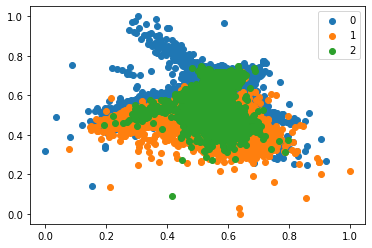

In [53]:
#get unique values for cluster labels, store in a variable for future use in plotting
unique_labels4 = np.unique(concat_df_copy['kmeans_cluster'])

#plotting the results:
for i in unique_labels4:
    plt.scatter(ssf_vectors[labels4 == i , 0] , ssf_vectors[labels4 == i, 1], label = i)
plt.legend()
plt.show()

In [54]:
concat_df_copy.loc[concat_df_copy['kmeans_cluster'] == 0]['danceability'].mean()
#highest liveness 2.635939178580282e-05
#highest loudness at -0.001727057681183373
#highest en count in this group at nearly 127k

2.9540430542930333e-05

In [55]:
concat_df_copy.loc[concat_df_copy['kmeans_cluster'] == 1]['danceability'].mean()
#lowest mean tempo 0.008027397707179256
#lowest energy 2.8681138711087608e-05
#lowest danceability at 3.440536078976386e-05
#highest pt count in this group around 92k

3.440536078976386e-05

In [56]:
concat_df_copy.loc[concat_df_copy['kmeans_cluster'] == 2]['danceability'].mean()
#lowest liveness 0.18949905304881384
#highest tempo 120.89870939892559
#highest energy 0.6932424064722764
#quietest at -6.754261443231799 for loudness
#highest for danceability at 0.6447632622034012

0.6447632622034012

In [57]:
#taking a look to see if I can visually identify any trends with lyrics
pt_concat = pd.concat([lyrics_csv, concat_df_copy], axis = 1).dropna()

In [58]:
pt_concat[pt_concat['kmeans_cluster'] == 0][pt_concat['language'] == 'en'].count()

/var/folders/zk/l8v61ht16ks5jp_8swnq6lhw0000gn/T/ipykernel_45099/434972995.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_concat[pt_concat['kmeans_cluster'] == 0][pt_concat['language'] == 'en'].count()


SName             126697
Lyric             126697
language          126697
0                 126697
1                 126697
2                 126697
3                 126697
4                 126697
5                 126697
6                 126697
7                 126697
8                 126697
9                 126697
10                126697
11                126697
12                126697
13                126697
14                126697
15                126697
liveness          126697
tempo             126697
energy            126697
loudness          126697
danceability      126697
kmeans_cluster    126697
dtype: int64

In [59]:
pt_concat[pt_concat['kmeans_cluster'] == 1][pt_concat['language'] == 'en'].count()

/var/folders/zk/l8v61ht16ks5jp_8swnq6lhw0000gn/T/ipykernel_45099/1177935372.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_concat[pt_concat['kmeans_cluster'] == 1][pt_concat['language'] == 'en'].count()


SName             46431
Lyric             46431
language          46431
0                 46431
1                 46431
2                 46431
3                 46431
4                 46431
5                 46431
6                 46431
7                 46431
8                 46431
9                 46431
10                46431
11                46431
12                46431
13                46431
14                46431
15                46431
liveness          46431
tempo             46431
energy            46431
loudness          46431
danceability      46431
kmeans_cluster    46431
dtype: int64

In [60]:
pt_concat[pt_concat['kmeans_cluster'] == 2][pt_concat['language'] == 'en'].count()

/var/folders/zk/l8v61ht16ks5jp_8swnq6lhw0000gn/T/ipykernel_45099/1524004634.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pt_concat[pt_concat['kmeans_cluster'] == 2][pt_concat['language'] == 'en'].count()


SName             12540
Lyric             12540
language          12540
0                 12540
1                 12540
2                 12540
3                 12540
4                 12540
5                 12540
6                 12540
7                 12540
8                 12540
9                 12540
10                12540
11                12540
12                12540
13                12540
14                12540
15                12540
liveness          12540
tempo             12540
energy            12540
loudness          12540
danceability      12540
kmeans_cluster    12540
dtype: int64

In [61]:
pt_concat

,SName,Lyric,language,0,1,2,3,4,5,6,...,12,13,14,15,liveness,tempo,energy,loudness,danceability,kmeans_cluster
0,Arerê,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt,0.103970,-0.393970,-0.020096,-0.491860,-0.246677,-0.020716,0.117633,...,-0.164242,0.151750,0.245546,0.378433,0.0887,97.091,0.401,-10.068,0.682,2.0
1,Se Eu Não Te Amasse Tanto Assim,Meu coração\nSem direção\nVoando só por voar\n...,pt,0.057642,-0.367321,0.015674,-0.401540,-0.249008,-0.047280,0.155120,...,-0.231976,0.166373,0.280226,0.377264,0.3470,135.225,0.880,-4.739,0.303,2.0
2,Céu da Boca,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt,0.029177,-0.336363,-0.019391,-0.277040,-0.224133,-0.040574,0.057677,...,-0.128773,0.147535,0.105516,0.409397,0.4890,111.904,0.652,-7.504,0.845,2.0
3,Quando A Chuva Passar,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt,0.066706,-0.366158,-0.037586,-0.463930,-0.257619,-0.032086,0.116477,...,-0.183700,0.099513,0.254212,0.406807,0.0664,118.593,0.378,-5.819,0.425,2.0
4,Sorte Grande,A minha sorte grande foi você cair do céu\nMin...,pt,0.091914,-0.349296,0.018885,-0.480658,-0.226570,-0.064574,0.145923,...,-0.088482,0.144970,0.256043,0.368271,0.1380,130.018,0.887,-1.993,0.760,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365289,Terra Sem Lei (Tierra Sin Nombre),Eu vou contar-lhes a história\nDe uma mulher q...,pt,0.043791,0.032718,-0.206075,0.023911,-0.066564,-0.008973,0.098771,...,0.132600,-0.050553,-0.060388,0.109231,0.0000,0.000,0.000,0.000,0.000,0.0
365290,Teu Orgulho,Amar igual te amei\nDuvido que alguém irá te a...,pt,0.073711,0.005936,-0.242408,0.005587,-0.052909,0.012972,0.082536,...,0.147235,-0.052258,-0.096599,0.127957,0.0000,0.000,0.000,0.000,0.000,0.0
365291,Todinha Pra Mim,Esta noite eu quero dormir em teus braços\nEst...,pt,0.047640,0.041018,-0.212754,0.059213,-0.085956,-0.015298,0.092890,...,0.162927,-0.035791,-0.068916,0.140874,0.0000,0.000,0.000,0.000,0.000,0.0
365292,Travesseiro de Pedra,Encoste aqui no meu ombro\nVem desabafar sua g...,pt,0.057413,-0.001897,-0.236947,0.058587,-0.070113,-0.001163,0.082289,...,0.129328,-0.068499,-0.060135,0.134603,0.0000,0.000,0.000,0.000,0.000,0.0


In [63]:
pt_concat['SName'].to_csv("../data/song_names.csv")
#exporting to csv so that I can use this in external models

In [77]:
np.save("song_vectors", ssf_vectors)

## Creating Playlists according to 20 most central points in each cluster

In [65]:
#find index of point closest to kmeans cluster centers. 

from scipy.spatial.distance import euclidean

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans4.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = ssf_vectors[kmeans4.labels_ == iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(kmeans4.labels_ == iclust)[0]

    cluster_cen = kmeans4.cluster_centers_[iclust]
    min_idx = np.argmin([euclidean(ssf_vectors[idx], cluster_cen) for idx in cluster_pts_indices])
    
    # Testing:    
    print('closest point to cluster center: ', cluster_pts[min_idx])
    print('closest index of point to cluster center: ', cluster_pts_indices[min_idx])
    print('  ', ssf_vectors[cluster_pts_indices[min_idx]])
    closest_pt_idx.append(cluster_pts_indices[min_idx])

closest point to cluster center:  [0.58257543 0.66852652 0.30488175 0.75471424 0.57797531 0.35415534
 0.7157782  0.39032537 0.48891767 0.55648057 0.72343422 0.66983311
 0.67314927 0.40929129 0.36273344 0.51623617 0.         0.
 0.         0.96414309 0.         0.        ]
closest index of point to cluster center:  177919
   [0.58257543 0.66852652 0.30488175 0.75471424 0.57797531 0.35415534
 0.7157782  0.39032537 0.48891767 0.55648057 0.72343422 0.66983311
 0.67314927 0.40929129 0.36273344 0.51623617 0.         0.
 0.         0.96414309 0.         0.        ]
closest point to cluster center:  [0.57296694 0.47811558 0.40261072 0.5412956  0.42126623 0.33056739
 0.75692541 0.3108907  0.38690296 0.65629427 0.62035069 0.4819618
 0.46398929 0.51778444 0.54326761 0.6121579  0.         0.
 0.         0.96414309 0.         0.        ]
closest index of point to cluster center:  179129
   [0.57296694 0.47811558 0.40261072 0.5412956  0.42126623 0.33056739
 0.75692541 0.3108907  0.38690296 0.6562942

In [66]:
#using indices from previous cell to get 20 nearest neighbours to the centroids 

from sklearn.neighbors import BallTree

X = ssf_vectors
def get_nearest_indices(X, closest_pt_idx):
    tree = BallTree(X, leaf_size=2)
    dist, ind = tree.query(X[closest_pt_idx], k = 20)
    return(ind)

get_nearest_indices(X, closest_pt_idx)

array([[177919, 176977, 288381, 238007, 289811, 150349, 172589, 177616,
        179290, 301024, 176747, 161258, 178051, 273772, 176984, 173806,
        161689, 169631, 173551, 177649],
       [179129, 283215, 284933, 283219, 283214, 284896, 174040, 172844,
        111262, 130171, 283236, 283218, 317207, 176484, 288541, 171177,
        291787, 284031, 127841,  64230],
       [ 12207,  15940,   6640,  17702,  11379,  12250,   8111,   7776,
         17624,  16644,  13243,  11862,  16642,   7313,  17309,  15637,
          4958,  16838,  13081,  12859]])

In [67]:
X = ssf_vectors
tree2 = BallTree(X, leaf_size=2)
dist, ind2 = tree2.query(X[np.where(pt_concat['SName'] == 'Arerê')], k = 20)
ind2

array([[    0,  3756,  2244,  2239,  2124,   761, 10891,  3334,  2657,
         2532, 16369,  2756, 14545,  4138,  3937,  3016,  2470, 17204,
         2931, 15289],
       [  611, 11457,  3355,  1570, 15689, 10844, 14428, 15337,  1222,
         3117,  2379,  3077,  2934,  1034,   890,   229,  1096, 14472,
        14543,   762],
       [ 2255,  2881, 10874,  3948,    72, 16478,  4319,  4117,  1165,
         1555,   483,  3883,  2086, 10860,  4497,  1050,  2977,  4320,
         1175,  1898]])

In [68]:
#song name stored in this variable by the form on the front end, inserting sample string here for testing purposes
song_name = 'Arerê'

def get_playlist(song_name):
    X = ssf_vectors
    tree2 = BallTree(X, leaf_size=2)
    dist, ind2 = tree2.query(X[np.where(pt_concat['SName'] == song_name)], k = 20)
    playlist = pt_concat[['SName']].iloc[ind2[0]]
    return playlist

get_playlist(song_name)

,SName
0,Arerê
3805,Dá Licença
2270,Abrigo
2265,Que Nem Feijão Com Arroz
2150,Na Natureza
773,Tão Seu
10967,Uma História Escrita Pelo Dedo de Deus
3375,Apanhadinha
2694,Uh Bebê
2563,Vida Rudimentar


In [69]:
playlist_1 = pt_concat[['SName']].iloc[ind2[0]]
playlist_1

,SName
0,Arerê
3805,Dá Licença
2270,Abrigo
2265,Que Nem Feijão Com Arroz
2150,Na Natureza
773,Tão Seu
10967,Uma História Escrita Pelo Dedo de Deus
3375,Apanhadinha
2694,Uh Bebê
2563,Vida Rudimentar


In [71]:
playlist_2 = pt_concat.iloc[ind2[1]]
playlist_2

,SName,Lyric,language,0,1,2,3,4,5,6,...,12,13,14,15,liveness,tempo,energy,loudness,danceability,kmeans_cluster
620,Arerê,Tudo que eu quero nessa vida\nToda vida é amar...,pt,0.031545,-0.588358,-0.002705,-0.670049,-0.348472,-0.017034,0.262747,...,-0.278363,0.247881,0.303496,0.485779,0.1160,72.936,0.316,-10.260,0.700,2.0
11534,Em Nagoya eu vi Eriko,Em Nagoya eu vi Eriko\nEla apareceu e sumiu tã...,pt,0.026869,0.032694,-0.193180,0.025413,-0.066837,-0.001038,0.080739,...,0.123077,-0.044736,-0.062822,0.138207,0.0740,134.219,0.667,-9.305,0.666,2.0
3397,Harém,Meu som tá batendo na cara\nO seu tá de brinqu...,pt,0.001436,-0.340389,0.015798,-0.300467,-0.158020,-0.103213,0.118373,...,-0.172295,0.061922,0.174489,0.190672,0.2680,120.574,0.756,-8.763,0.433,2.0
1590,Longínquo Longe,Quero uma mulher\nQue me acompanhe\nNa hora de...,pt,-0.004877,-0.406004,-0.051183,-0.561387,-0.220195,0.035059,0.125598,...,-0.146515,0.105064,0.225512,0.343614,0.4720,136.465,0.551,-8.096,0.432,2.0
15808,Barco à Vela,Já não tenho tempo pra esperar\nFiz o impossív...,pt,-0.036271,0.004025,-0.116063,-0.015021,0.000896,0.008190,-0.003687,...,0.026759,-0.052797,0.000651,0.095962,0.1170,134.945,0.655,-5.021,0.672,2.0
10920,Meu Futuro (Feat. Dany Campos),Olho para o meu futuro\nSimplesmente vejo a mã...,pt,0.050227,0.021036,-0.184752,0.024823,-0.052860,-0.021109,0.106028,...,0.103647,-0.060896,-0.071643,0.122104,0.0673,129.537,0.654,-12.421,0.579,2.0
14542,Último Dia,Então vê se vigia e se hoje for teu Último Dia...,pt,0.051280,-0.371923,-0.005600,-0.509911,-0.254398,-0.034504,0.115170,...,-0.138878,0.124529,0.244979,0.386985,0.0969,126.015,0.837,-2.063,0.658,2.0
15456,Quem Te Viu,"Eu vi e vivi varias fitas, que 'cê' nem acredi...",pt,0.051446,0.044157,-0.198422,0.033587,-0.039719,0.006426,0.080267,...,0.108833,-0.050564,-0.060413,0.147636,0.0650,119.951,0.590,-9.206,0.790,2.0
1235,Nova Dança/rebolado/te Desejo (minha Inha),"E aconteceu, chegou mãe\nQuem não ficou, não v...",pt,-0.043630,-0.386640,-0.014245,-0.522834,-0.273253,-0.037838,0.105340,...,-0.224202,0.119437,0.243498,0.357531,0.3630,122.990,0.830,-5.820,0.554,2.0
3155,Boa Noite,Meu ar de dominador\nDizia que eu ia ser seu d...,pt,0.097964,-0.445980,0.005279,-0.551446,-0.306902,-0.020644,0.266800,...,-0.240912,0.122243,0.334087,0.531958,0.0444,100.005,0.679,-5.843,0.774,2.0


In [73]:
playlist_3 = pt_concat.iloc[ind2[2]]
playlist_3

,SName,Lyric,language,0,1,2,3,4,5,6,...,12,13,14,15,liveness,tempo,energy,loudness,danceability,kmeans_cluster
2281,Arerê,"Chora, mas chora baixinho\nNo meu ouvidinho pr...",pt,-0.011561,-0.388732,0.005363,-0.471962,-0.247627,0.009383,0.145316,...,-0.101865,0.147359,0.258164,0.386188,0.1020,119.996,0.777,-7.076,0.733,2.0
2919,Caçador de Mim,Por tanto amor\nPor tanta emoção\nA vida me fe...,pt,0.040691,-0.382013,0.022987,-0.406190,-0.216597,-0.057695,0.099616,...,-0.109703,0.132512,0.192015,0.337455,0.1640,140.358,0.759,-5.573,0.278,2.0
10950,Sacrifício,"Jesus, o único filho de Deus\nA alegria e o pr...",pt,0.013912,0.039367,-0.167489,0.020221,-0.037493,-0.015809,0.065842,...,0.056372,-0.044711,-0.058684,0.142071,0.6170,127.844,0.916,-4.715,0.565,2.0
4001,Abra O Seu Coração,Um dia te faço feliz\nMas não tem que ser agor...,pt,0.043163,-0.355850,0.015197,-0.404898,-0.237849,-0.091177,0.171563,...,-0.190060,0.164320,0.179776,0.332364,0.1000,80.417,0.839,-8.775,0.676,2.0
72,Chão da Praça,"Meu amor, quem ficou\nNesta dança, meu amor\nT...",pt,-0.077146,-0.369425,0.029036,-0.447877,-0.249345,-0.044290,0.138595,...,-0.124424,0.101875,0.238306,0.405980,0.2170,79.721,0.606,-7.552,0.663,2.0
16598,Primeiro Amor,Anseio ouvir o indizível\nDesejo ver teu coraç...,pt,0.001886,0.034660,-0.176996,0.023391,-0.019255,0.049641,0.116835,...,0.064612,-0.004897,-0.095975,0.170707,0.0979,85.012,0.512,-6.468,0.901,2.0
4376,Coisa de Bamba,"Vem sambar miudinho\nMinha preta\nÔ Dinorá, Di...",pt,-0.024584,-0.267142,0.006326,-0.381469,-0.187356,-0.046618,0.115447,...,-0.062566,0.133994,0.208969,0.309064,0.0661,111.786,0.833,-6.041,0.715,2.0
4173,Sei O Que Quer Tome Ai,Ai mainha já sei porque você voltou\nAndou rod...,pt,0.015825,-0.355500,-0.014131,-0.410389,-0.303520,0.004142,0.124310,...,-0.252672,0.151154,0.235866,0.321345,0.1080,137.088,0.410,-9.815,0.317,2.0
1178,Eu Vou Pra Quebrar,Vai\nÉ o harmonia que passa\nLidera a galera\n...,pt,0.060438,-0.424811,-0.011336,-0.555048,-0.314181,-0.037414,0.149637,...,-0.171466,0.148385,0.247947,0.466030,0.1140,112.970,0.590,-7.818,0.829,2.0
1575,Geléia Geral,Um poeta desfolha a bandeira\n\nE a manhã trop...,pt,-0.050372,-0.367909,-0.015363,-0.438155,-0.228028,-0.034702,0.126373,...,-0.093175,0.077222,0.195495,0.312104,0.1250,81.441,0.549,-5.695,0.684,2.0


## Pickling Kmeans model

In [ ]:
import pickle
pickle.dump(kmeans4, open('kmeans4.pkl','wb'))

In [80]:
np.load("//Users/sabinagrossman/Documents/GitHub/song_vectors.npy")[np.where(pt_concat['SName'] == song_name)]

array([[0.63039023, 0.47875465, 0.39696753, 0.52202424, 0.4302914 ,
        0.3415668 , 0.73650066, 0.32067115, 0.38299081, 0.652512  ,
        0.63380811, 0.44117032, 0.46497517, 0.52923449, 0.55116409,
        0.6086774 , 0.08905622, 0.45359664, 0.401     , 0.68100006,
        0.69662921, 0.33333333],
       [0.62607579, 0.45327738, 0.39345511, 0.51291998, 0.41775988,
        0.31047848, 0.7168881 , 0.33506894, 0.38433172, 0.63814444,
        0.64168671, 0.45453093, 0.50671378, 0.53414849, 0.57415839,
        0.61140059, 0.11546185, 0.47659159, 0.634     , 0.8228528 ,
        0.69356486, 1.        ],
       [0.52609206, 0.49357264, 0.40241662, 0.57243368, 0.40047447,
        0.30929118, 0.74864723, 0.29242802, 0.39611135, 0.62634762,
        0.72668432, 0.55192208, 0.5259445 , 0.59520314, 0.53903231,
        0.57166262, 0.23192771, 0.40635935, 0.631     , 0.76056021,
        0.64453524, 1.        ]])

In [117]:
name = 'Céu da boca'
data = np.load("//Users/sabinagrossman/Documents/GitHub/song_vectors.npy")[np.where(pt_concat['SName'] == song_name)].astype(float)
data

array([[0.63039023, 0.47875465, 0.39696753, 0.52202424, 0.4302914 ,
        0.3415668 , 0.73650066, 0.32067115, 0.38299081, 0.652512  ,
        0.63380811, 0.44117032, 0.46497517, 0.52923449, 0.55116409,
        0.6086774 , 0.08905622, 0.45359664, 0.401     , 0.68100006,
        0.69662921, 0.33333333],
       [0.62607579, 0.45327738, 0.39345511, 0.51291998, 0.41775988,
        0.31047848, 0.7168881 , 0.33506894, 0.38433172, 0.63814444,
        0.64168671, 0.45453093, 0.50671378, 0.53414849, 0.57415839,
        0.61140059, 0.11546185, 0.47659159, 0.634     , 0.8228528 ,
        0.69356486, 1.        ],
       [0.52609206, 0.49357264, 0.40241662, 0.57243368, 0.40047447,
        0.30929118, 0.74864723, 0.29242802, 0.39611135, 0.62634762,
        0.72668432, 0.55192208, 0.5259445 , 0.59520314, 0.53903231,
        0.57166262, 0.23192771, 0.40635935, 0.631     , 0.76056021,
        0.64453524, 1.        ]])

In [127]:
    song_name = "Arerê"
    ssf_vectors = np.fromfile("//Users/sabinagrossman/Documents/GitHub/song_vectors").reshape(-1,1)
    X = ssf_vectors
    tree = BallTree(X, leaf_size=2)
    ind = tree.query(X[np.where(pt_concat['SName'] == song_name)], k = 20)
    playlist = pt_concat['SName'].loc[ind[0][0]]
    playlist

KeyError: '[1.3428124630189879e-79, 1.3480835619906032e-79, 1.68543389617398e-79, 2.0254197798431643e-79, 2.362770114026541e-79, 2.6948493492383025e-79, 2.698802673467014e-79, 3.3655966933763445e-79, 3.3669144681192484e-79, 3.712171450760048e-79, 8.265214964967021e-78, 8.333080364226567e-78, 8.3997597662175e-78, 8.400286876114662e-78, 8.400418653588952e-78, 8.43415368700729e-78, 8.468020497899918e-78, 8.501228421421094e-78, 8.501623753843965e-78] not in index'

In [125]:
ind[0][0]

array([0.00000000e+00, 1.34281246e-79, 1.34808356e-79, 1.68543390e-79,
       2.02541978e-79, 2.36277011e-79, 2.69484935e-79, 2.69880267e-79,
       3.36559669e-79, 3.36691447e-79, 3.71217145e-79, 8.26521496e-78,
       8.33308036e-78, 8.39975977e-78, 8.40028688e-78, 8.40041865e-78,
       8.43415369e-78, 8.46802050e-78, 8.50122842e-78, 8.50162375e-78])